In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# folder with E0.csv ... E7.csv
DATA_PATH = Path('/home/mann-gandhi/Documents/GitHub-Repositories/Arsenal/data')

# Columns you want (canonical names)
KEEP_COLS = [
    'Div','Date','Time','HomeTeam','AwayTeam',
    'FTHG','FTAG','FTR','HTHG','HTAG','HTR',
    'Attendance','Referee','HS','AS','HST','AST',
    'HHW','AHW','HC','AC','HF','AF','HFKC','AFKC','HO','AO',
    'HY','AY','HR','AR','HBP','ABP',
    'League'  # we'll add this
]

# Some files use alternative names → normalize to canonical names
RENAME_MAP = {
    'HG': 'FTHG',     # Full Time Home Goals
    'AG': 'FTAG',     # Full Time Away Goals
    'Res': 'FTR',     # Full Time Result
}

TEXT_COLS = {'Div','Date','Time','HomeTeam','AwayTeam','FTR','HTR','Referee','League'}

def load_one(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, low_memory=False, encoding='utf-8')

    # standardize column names where alternates appear
    present_renames = {k: v for k, v in RENAME_MAP.items() if k in df.columns}
    if present_renames:
        df = df.rename(columns=present_renames)

    # add League from filename (E0.csv -> E0)
    m = re.match(r'(E\d+)\.csv$', path.name)
    df['League'] = m.group(1) if m else path.stem

    # parse dates (dd/mm/yy) and times if present
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    if 'Time' in df.columns:
        # be forgiving about format; keep as time
        t = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce')
        df['Time'] = t.dt.time

    # keep ONLY the requested columns that exist in this file
    cols_here = [c for c in KEEP_COLS if c in df.columns]
    df = df[cols_here]

    # numeric coercion for stats/integers; leave text columns alone
    for c in df.columns:
        if c not in TEXT_COLS:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    return df

# ---- Load and merge ----
csv_files = sorted(p for p in DATA_PATH.glob('E0.csv') if p.is_file()) # change E0 to E* for all past 7 seasons data for a range use E[0-3]
frames = [load_one(p) for p in csv_files]
combined_df = pd.concat(frames, ignore_index=True, sort=False)

print("Loaded files:", [p.name for p in csv_files])
print("Combined shape:", combined_df.shape)
combined_df.head(5)


Loaded files: ['E0.csv']
Combined shape: (110, 25)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AST,HC,AC,HF,AF,HY,AY,HR,AR,League
0,E0,2025-08-15,20:00:00,Liverpool,Bournemouth,4,2,H,1,0,...,3,6,7,7,10,1,2,0,0,E0
1,E0,2025-08-16,12:30:00,Aston Villa,Newcastle,0,0,D,0,0,...,3,3,6,13,11,1,1,1,0,E0
2,E0,2025-08-16,15:00:00,Brighton,Fulham,1,1,D,0,0,...,2,4,3,16,15,3,3,0,0,E0
3,E0,2025-08-16,15:00:00,Sunderland,West Ham,3,0,H,0,0,...,4,5,7,8,10,0,1,0,0,E0
4,E0,2025-08-16,15:00:00,Tottenham,Burnley,3,0,H,1,0,...,4,6,5,14,8,0,0,0,0,E0


In [21]:
import pandas as pd
import numpy as np

df = combined_df.copy()

# Ensure totals exist (match-level)
df['TotalGoals'] = df[['FTHG','FTAG']].sum(axis=1)

# Helper mappings to build per-team rows
home_cols = {
    'Team':'HomeTeam', 'Opp':'AwayTeam',
    'GF':'FTHG', 'GA':'FTAG',
    'Shots':'HS', 'SOT':'HST',
    'Corners':'HC', 'Fouls':'HF', 'Offsides':'HO',
    'Yellows':'HY', 'Reds':'HR', 'BookingsPts':'HBP',
}
away_cols = {
    'Team':'AwayTeam', 'Opp':'HomeTeam',
    'GF':'FTAG', 'GA':'FTHG',
    'Shots':'AS', 'SOT':'AST',
    'Corners':'AC', 'Fouls':'AF', 'Offsides':'AO',
    'Yellows':'AY', 'Reds':'AR', 'BookingsPts':'ABP',
}

def _num_series_or_na(d: pd.DataFrame, colname: str, index_like) -> pd.Series:
    """Return numeric series for d[colname] or a NA-filled series if missing."""
    if colname in d.columns:
        return pd.to_numeric(d[colname], errors='coerce')
    # Create a nullable float series of NA if column is absent in this CSV
    return pd.Series(pd.NA, index=index_like, dtype="Float64")

def side_frame(d: pd.DataFrame, mapping: dict, is_home: bool) -> pd.DataFrame:
    idx = d.index
    out = pd.DataFrame({
        'League': d['League'],
        'Div': d['Div'] if 'Div' in d.columns else d['League'],
        'Date': d['Date'],
        'Time': d['Time'] if 'Time' in d.columns else pd.NaT,
        'Team': d[mapping['Team']],
        'Opponent': d[mapping['Opp']],
        'Venue': 'H' if is_home else 'A',
        'GF': _num_series_or_na(d, mapping['GF'], idx),
        'GA': _num_series_or_na(d, mapping['GA'], idx),
        'Shots': _num_series_or_na(d, mapping['Shots'], idx),
        'SOT': _num_series_or_na(d, mapping['SOT'], idx),
        'Corners': _num_series_or_na(d, mapping['Corners'], idx),
        'Fouls': _num_series_or_na(d, mapping['Fouls'], idx),
        'Offsides': _num_series_or_na(d, mapping['Offsides'], idx),
        'Yellows': _num_series_or_na(d, mapping['Yellows'], idx),
        'Reds': _num_series_or_na(d, mapping['Reds'], idx),
        'BookingsPts': _num_series_or_na(d, mapping['BookingsPts'], idx),
        'Attendance': _num_series_or_na(d, 'Attendance', idx) if is_home else pd.Series(pd.NA, index=idx, dtype="Float64"),
        'Referee': d['Referee'] if 'Referee' in d.columns else pd.Series(pd.NA, index=idx, dtype="string"),
    })
    return out

home = side_frame(df, home_cols, is_home=True)
away = side_frame(df, away_cols, is_home=False)

team_matches = pd.concat([home, away], ignore_index=True)

# ---- Derived fields (robust dtypes) ----
team_matches['GD'] = team_matches['GF'] - team_matches['GA']

# Result as string dtype; avoid np.nan default (dtype clash)
result_arr = np.select(
    [team_matches['GD'] > 0, team_matches['GD'] == 0, team_matches['GD'] < 0],
    ['W', 'D', 'L'],
    default=None
)
team_matches['Result'] = pd.Series(result_arr, dtype='string')

# Points as pandas nullable integer (or Float64 if you prefer)
points_arr = np.select(
    [team_matches['Result'] == 'W', team_matches['Result'] == 'D', team_matches['Result'] == 'L'],
    [3, 1, 0],
    default=np.nan
)
team_matches['Points'] = pd.Series(points_arr, dtype='Int64')

team_matches['CleanSheet'] = team_matches['GA'].eq(0)

# Shot accuracy: avoid divide-by-zero and infinities
shots = team_matches['Shots'].astype('Float64')
sot = team_matches['SOT'].astype('Float64')
team_matches['ShotAccuracy'] = (sot / shots).where(shots > 0)  # stays NA if shots==0 or missing

print(team_matches.shape)
team_matches.head(10)


(220, 24)


,League,Div,Date,Time,Team,Opponent,Venue,GF,GA,Shots,...,Yellows,Reds,BookingsPts,Attendance,Referee,GD,Result,Points,CleanSheet,ShotAccuracy
0,E0,E0,2025-08-15,20:00:00,Liverpool,Bournemouth,H,4,2,19,...,1,0,<NA>,<NA>,A Taylor,2,W,3,False,0.526316
1,E0,E0,2025-08-16,12:30:00,Aston Villa,Newcastle,H,0,0,3,...,1,1,<NA>,<NA>,C Pawson,0,D,1,True,1.0
2,E0,E0,2025-08-16,15:00:00,Brighton,Fulham,H,1,1,10,...,3,0,<NA>,<NA>,S Barrott,0,D,1,False,0.4
3,E0,E0,2025-08-16,15:00:00,Sunderland,West Ham,H,3,0,10,...,0,0,<NA>,<NA>,R Jones,3,W,3,True,0.5
4,E0,E0,2025-08-16,15:00:00,Tottenham,Burnley,H,3,0,16,...,0,0,<NA>,<NA>,M Oliver,3,W,3,True,0.375
5,E0,E0,2025-08-16,17:30:00,Wolves,Man City,H,0,4,9,...,1,0,<NA>,<NA>,J Gillett,-4,L,0,False,0.333333
6,E0,E0,2025-08-17,14:00:00,Chelsea,Crystal Palace,H,0,0,19,...,2,0,<NA>,<NA>,D England,0,D,1,True,0.157895
7,E0,E0,2025-08-17,14:00:00,Nott'm Forest,Brentford,H,3,1,11,...,1,0,<NA>,<NA>,P Bankes,2,W,3,False,0.454545
8,E0,E0,2025-08-17,16:30:00,Man United,Arsenal,H,0,1,22,...,1,0,<NA>,<NA>,S Hooper,-1,L,0,False,0.318182
9,E0,E0,2025-08-18,20:00:00,Leeds,Everton,H,1,0,21,...,0,0,<NA>,<NA>,C Kavanagh,1,W,3,True,0.142857


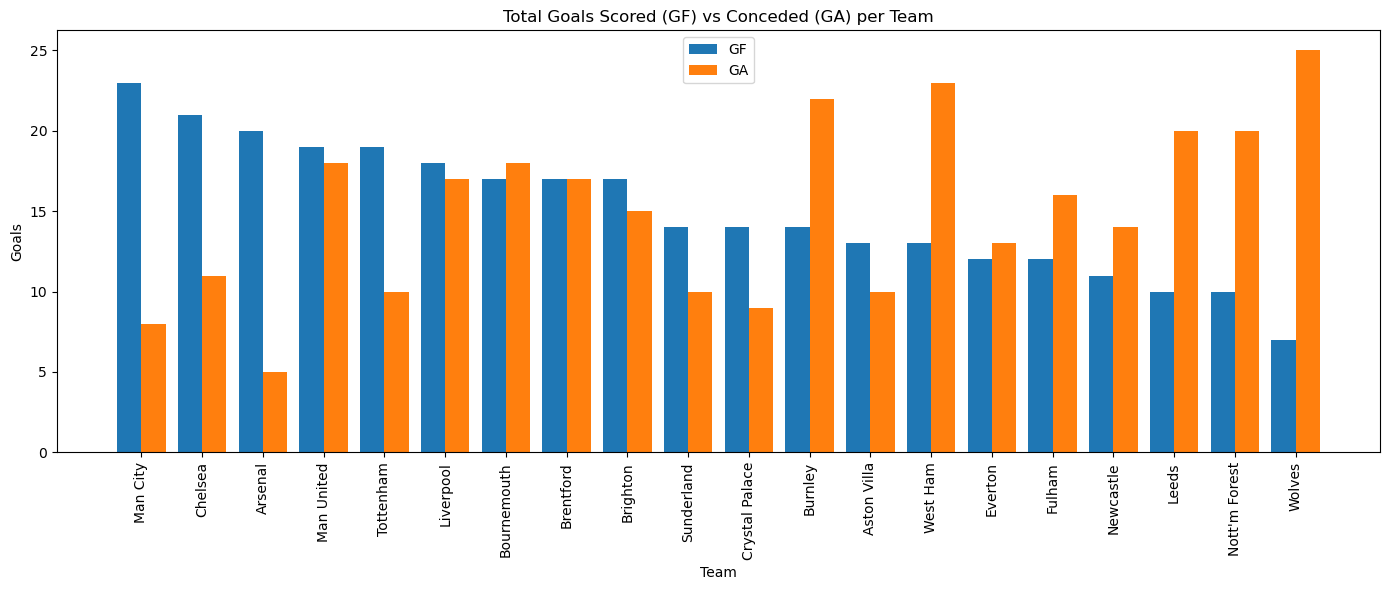

In [22]:
team_goals = (team_matches.groupby('Team')[['GF', 'GA']]
              .sum()
              .sort_values('GF', ascending=False))

x = range(len(team_goals))
width = 0.4

plt.figure(figsize=(14, 6))
plt.bar([i - width/2 for i in x], team_goals['GF'].values, width=0.4, label='GF')
plt.bar([i + width/2 for i in x], team_goals['GA'].values, width=0.4, label='GA')
plt.title('Total Goals Scored (GF) vs Conceded (GA) per Team')
plt.xlabel('Team')
plt.ylabel('Goals')
plt.xticks(ticks=x, labels=team_goals.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


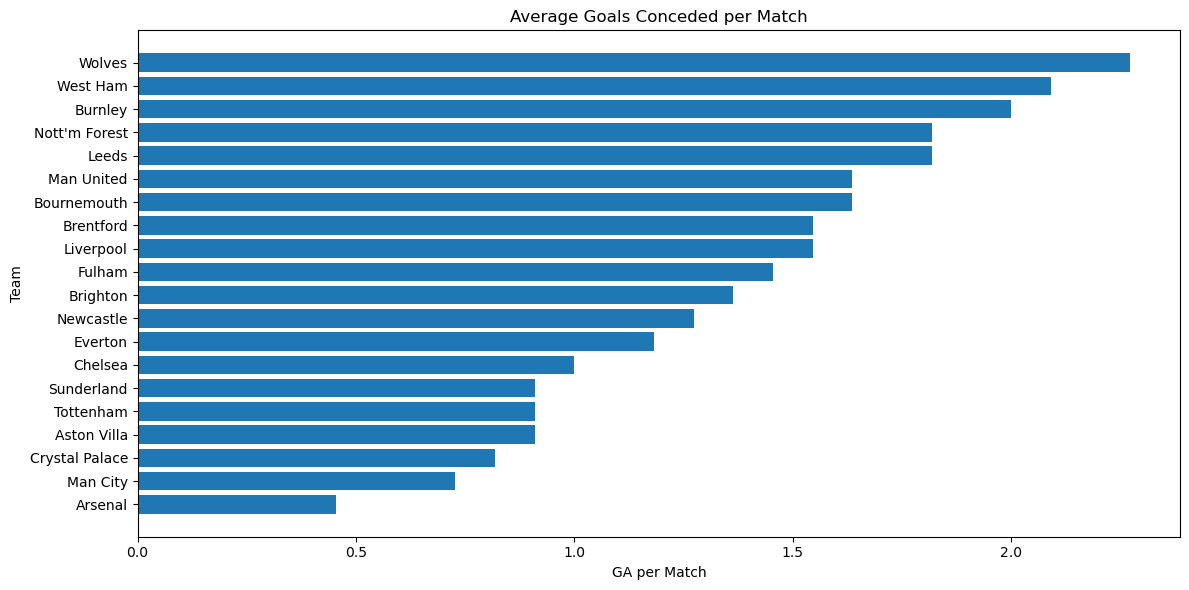

In [23]:
ga_per_match = (team_matches.groupby('Team')['GA']
                .mean()
                .sort_values(ascending=True))

plt.figure(figsize=(12, 6))
plt.barh(ga_per_match.index, ga_per_match.values)
plt.title('Average Goals Conceded per Match')
plt.xlabel('GA per Match')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


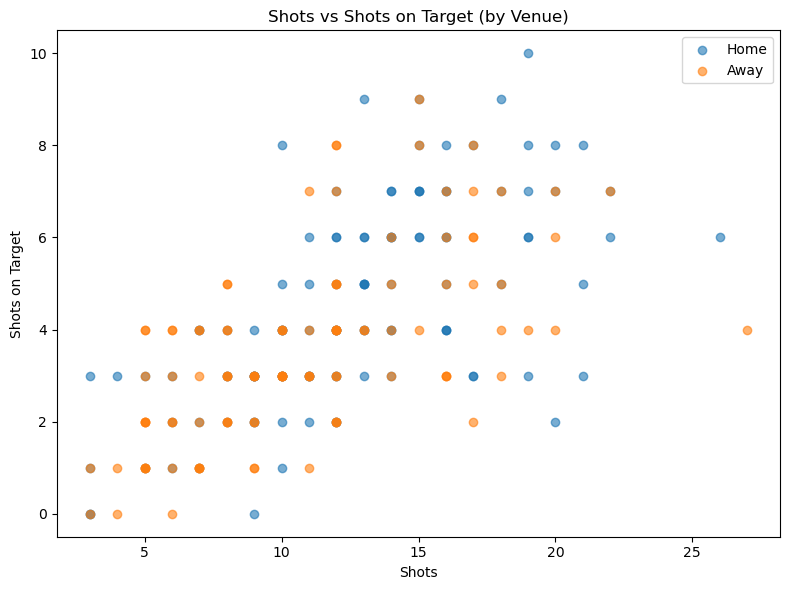

In [24]:
mask = team_matches['Shots'].notna() & team_matches['SOT'].notna()

plt.figure(figsize=(8, 6))
# Home
mh = mask & (team_matches['Venue'] == 'H')
plt.scatter(team_matches.loc[mh, 'Shots'], team_matches.loc[mh, 'SOT'], alpha=0.6, label='Home')
# Away
ma = mask & (team_matches['Venue'] == 'A')
plt.scatter(team_matches.loc[ma, 'Shots'], team_matches.loc[ma, 'SOT'], alpha=0.6, label='Away')

plt.title('Shots vs Shots on Target (by Venue)')
plt.xlabel('Shots')
plt.ylabel('Shots on Target')
plt.legend()
plt.tight_layout()
plt.show()


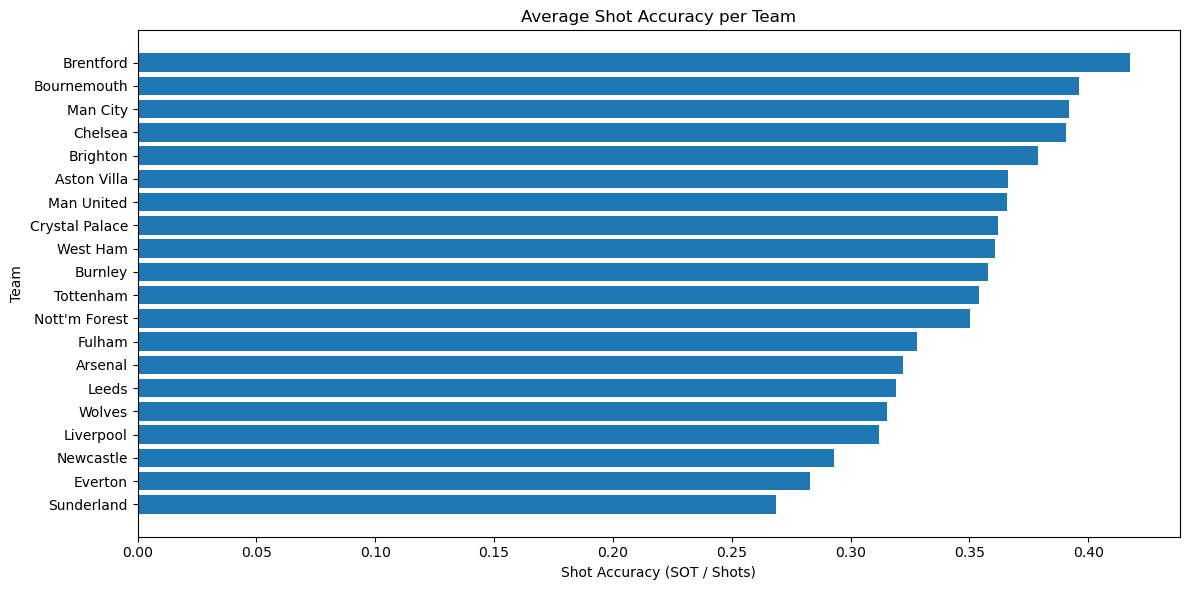

In [25]:
import numpy as np

shot_acc = (team_matches.groupby('Team')['ShotAccuracy']
            .mean()
            .replace([np.inf, -np.inf], np.nan)
            .dropna()
            .sort_values(ascending=False))

plt.figure(figsize=(12, 6))
plt.barh(shot_acc.index, shot_acc.values)
plt.gca().invert_yaxis()
plt.title('Average Shot Accuracy per Team')
plt.xlabel('Shot Accuracy (SOT / Shots)')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


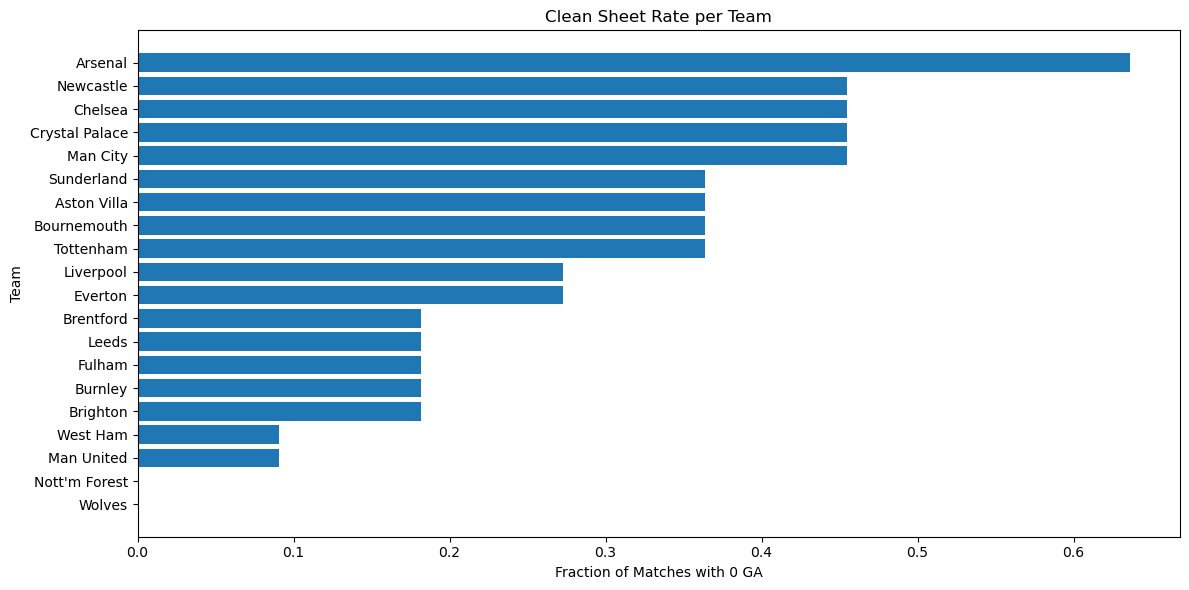

In [26]:
cs_rate = (team_matches.groupby('Team')['CleanSheet']
           .mean()
           .sort_values(ascending=False))

plt.figure(figsize=(12, 6))
plt.barh(cs_rate.index, cs_rate.values)
plt.gca().invert_yaxis()
plt.title('Clean Sheet Rate per Team')
plt.xlabel('Fraction of Matches with 0 GA')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


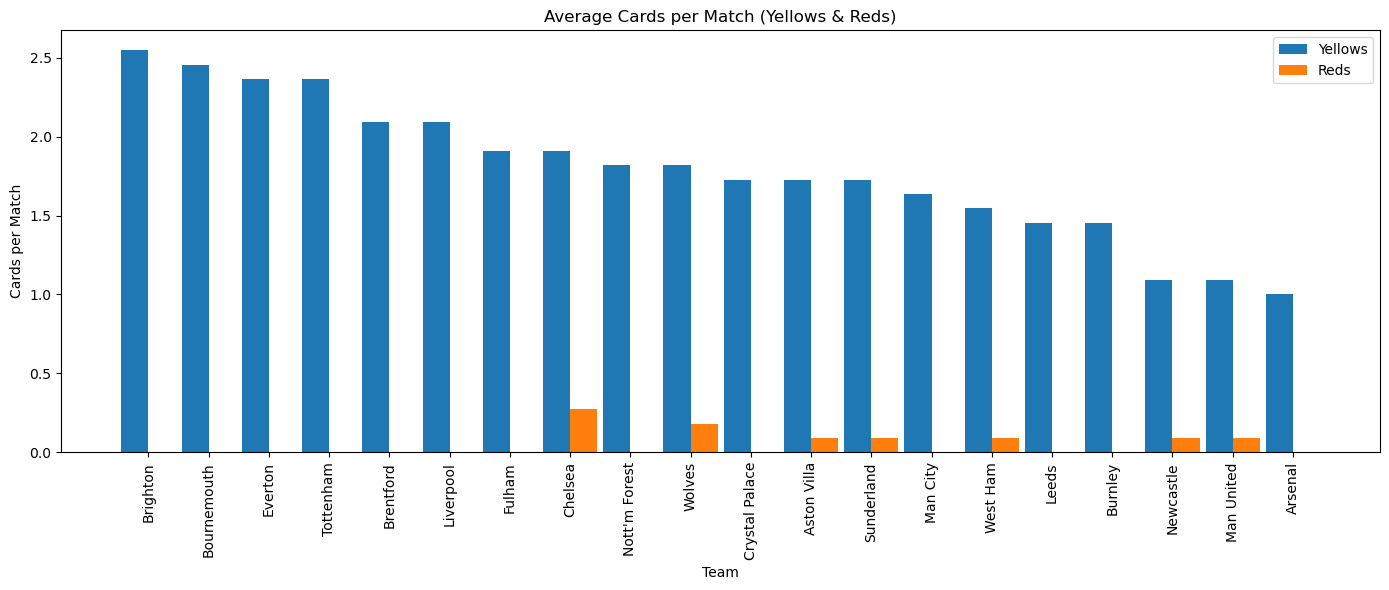

In [27]:
disc = (team_matches.groupby('Team')[['Yellows','Reds']]
        .mean()
        .sort_values('Yellows', ascending=False))

x = range(len(disc))
width = 0.45

plt.figure(figsize=(14, 6))
plt.bar([i - width/2 for i in x], disc['Yellows'].values, width=width, label='Yellows')
plt.bar([i + width/2 for i in x], disc['Reds'].values, width=width, label='Reds')
plt.title('Average Cards per Match (Yellows & Reds)')
plt.xlabel('Team')
plt.ylabel('Cards per Match')
plt.xticks(ticks=x, labels=disc.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


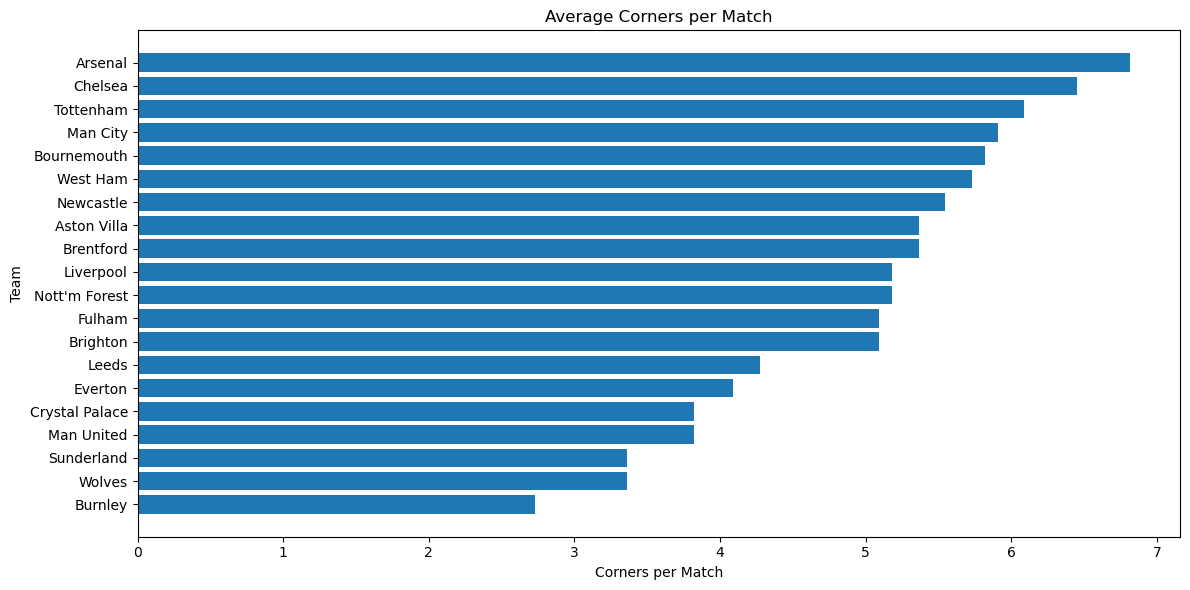

In [28]:
corners_pm = (team_matches.groupby('Team')['Corners']
              .mean()
              .sort_values(ascending=False))

plt.figure(figsize=(12, 6))
plt.barh(corners_pm.index, corners_pm.values)
plt.gca().invert_yaxis()
plt.title('Average Corners per Match')
plt.xlabel('Corners per Match')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


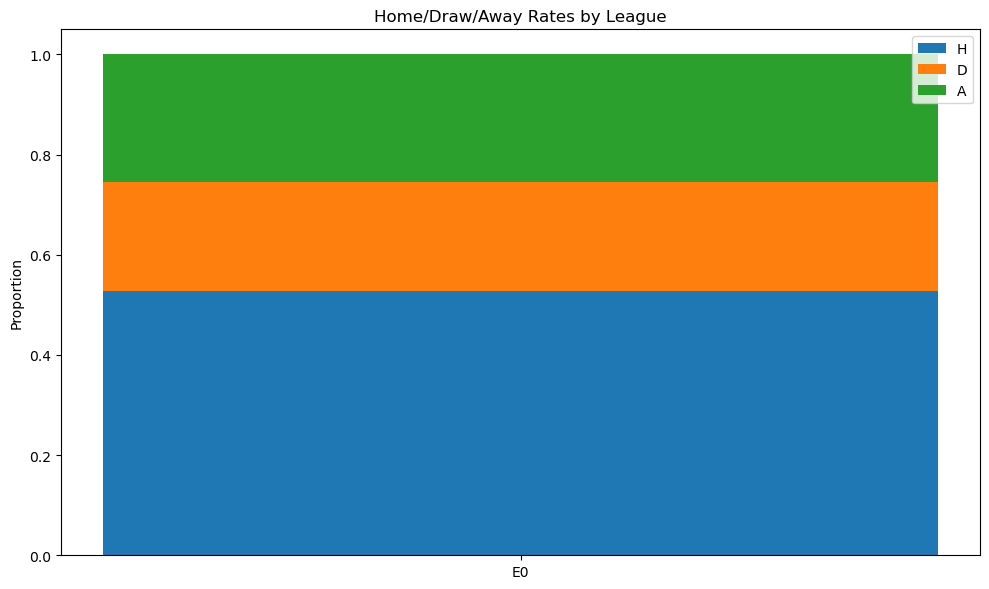

In [29]:
# From combined_df (match-level)
out_counts = (combined_df.groupby(['League','FTR'])
              .size()
              .unstack(fill_value=0))
rates = out_counts.div(out_counts.sum(axis=1), axis=0).loc[:, ['H','D','A']]

x = range(len(rates))
plt.figure(figsize=(10, 6))
bottom = np.zeros(len(rates))
for label in ['H','D','A']:
    vals = rates[label].values if label in rates.columns else np.zeros(len(rates))
    plt.bar(x, vals, bottom=bottom, label=label)
    bottom += vals

plt.xticks(ticks=x, labels=rates.index)
plt.ylabel('Proportion')
plt.title('Home/Draw/Away Rates by League')
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
TEAM = "Brentford" # change Team name to select  a specific Premier League team

tm_team = team_matches[team_matches["Team"] == TEAM].copy()
assert not tm_team.empty, f"No rows found for team '{TEAM}'. Check exact name in your data."

# Helpful extras
tm_team["Year"] = tm_team["Date"].dt.year
tm_team["Month"] = tm_team["Date"].dt.to_period("M").astype(str)  # e.g. '2025-08'
tm_team["GF"] = tm_team["GF"].astype("Float64")
tm_team["GA"] = tm_team["GA"].astype("Float64")
tm_team["Shots"] = tm_team["Shots"].astype("Float64")
tm_team["SOT"] = tm_team["SOT"].astype("Float64")
tm_team["ShotAccuracy"] = (tm_team["SOT"] / tm_team["Shots"]).where(tm_team["Shots"] > 0)
tm_team["Points"] = tm_team["Points"].astype("Float64")
tm_team["GD"] = tm_team["GF"] - tm_team["GA"]

print(TEAM, "matches:", len(tm_team))
tm_team.head(10)


Brentford matches: 11


,League,Div,Date,Time,Team,Opponent,Venue,GF,GA,Shots,...,BookingsPts,Attendance,Referee,GD,Result,Points,CleanSheet,ShotAccuracy,Year,Month
13,E0,E0,2025-08-23,15:00:00,Brentford,Aston Villa,H,1.0,0.0,9.0,...,<NA>,<NA>,T Harrington,1.0,W,3.0,True,0.222222,2025,2025-08
37,E0,E0,2025-09-13,20:00:00,Brentford,Chelsea,H,2.0,2.0,7.0,...,<NA>,<NA>,S Attwell,0.0,D,1.0,False,0.571429,2025,2025-09
50,E0,E0,2025-09-27,12:30:00,Brentford,Man United,H,3.0,1.0,10.0,...,<NA>,<NA>,C Pawson,2.0,W,3.0,False,0.8,2025,2025-09
69,E0,E0,2025-10-05,16:30:00,Brentford,Man City,H,0.0,1.0,6.0,...,<NA>,<NA>,D England,-1.0,L,0.0,False,0.166667,2025,2025-10
84,E0,E0,2025-10-25,20:00:00,Brentford,Liverpool,H,3.0,2.0,17.0,...,<NA>,<NA>,S Hooper,1.0,W,3.0,False,0.470588,2025,2025-10
106,E0,E0,2025-11-09,14:00:00,Brentford,Newcastle,H,3.0,1.0,15.0,...,<NA>,<NA>,S Attwell,2.0,W,3.0,False,0.466667,2025,2025-11
117,E0,E0,2025-08-17,14:00:00,Brentford,Nott'm Forest,A,1.0,3.0,10.0,...,<NA>,<NA>,P Bankes,-2.0,L,0.0,False,0.3,2025,2025-08
132,E0,E0,2025-08-30,15:00:00,Brentford,Sunderland,A,1.0,2.0,7.0,...,<NA>,<NA>,A Taylor,-1.0,L,0.0,False,0.571429,2025,2025-08
156,E0,E0,2025-09-20,20:00:00,Brentford,Fulham,A,1.0,3.0,8.0,...,<NA>,<NA>,M Oliver,-2.0,L,0.0,False,0.375,2025,2025-09
189,E0,E0,2025-10-20,20:00:00,Brentford,West Ham,A,2.0,0.0,22.0,...,<NA>,<NA>,A Madley,2.0,W,3.0,True,0.318182,2025,2025-10


Brentford — Matches: 11, W-D-L: 5-1-5
Goals: GF = 17.0 GA = 17.0 GD = 0.0
Points: 16.0  | Pts/Match: 1.4545454545454546

Results by Venue:
 Result  D  L  W
Venue          
A       0  4  1
H       1  1  4


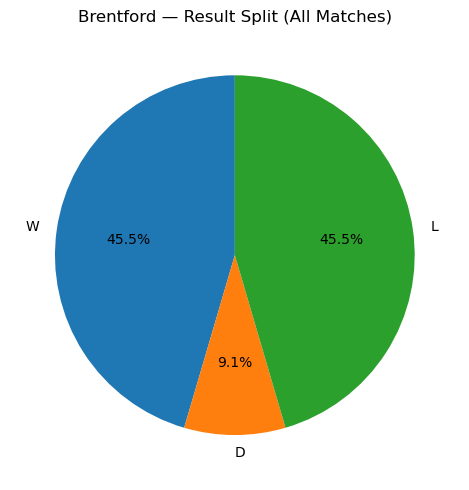

In [31]:
# Overall record
total_matches = len(tm_team)
wins = (tm_team["Result"] == "W").sum()
draws = (tm_team["Result"] == "D").sum()
losses = (tm_team["Result"] == "L").sum()

print(f"{TEAM} — Matches: {total_matches}, W-D-L: {wins}-{draws}-{losses}")
print("Goals: GF =", tm_team["GF"].sum(), "GA =", tm_team["GA"].sum(), "GD =", (tm_team["GF"].sum() - tm_team["GA"].sum()))
print("Points:", tm_team["Points"].sum(), " | Pts/Match:", tm_team["Points"].mean())

# Venue splits
venue_counts = tm_team.groupby("Venue")["Result"].value_counts().unstack(fill_value=0)
print("\nResults by Venue:\n", venue_counts)

# Plot W/D/L proportion overall
labels = ["W","D","L"]
vals = [wins, draws, losses]

plt.figure(figsize=(5,5))
plt.pie(vals, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title(f"{TEAM} — Result Split (All Matches)")
plt.tight_layout()
plt.show()


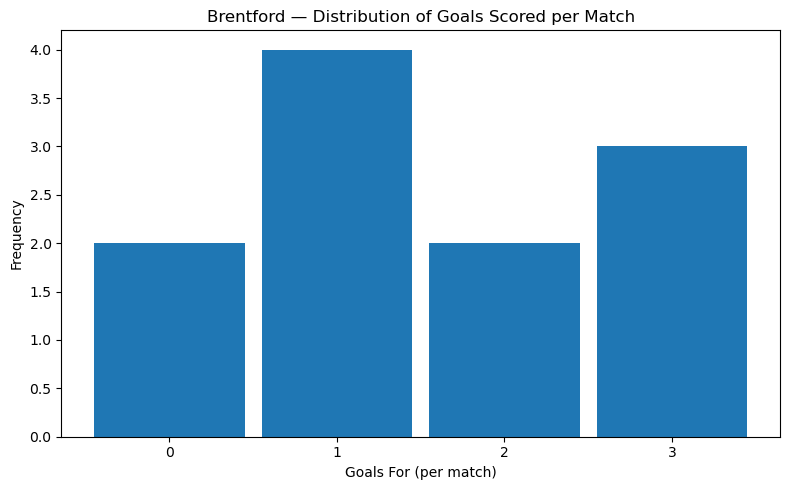

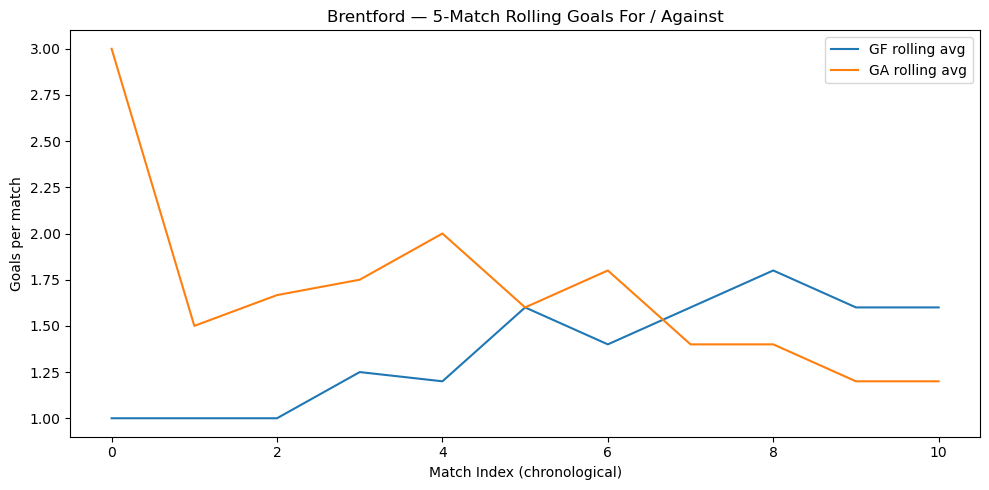

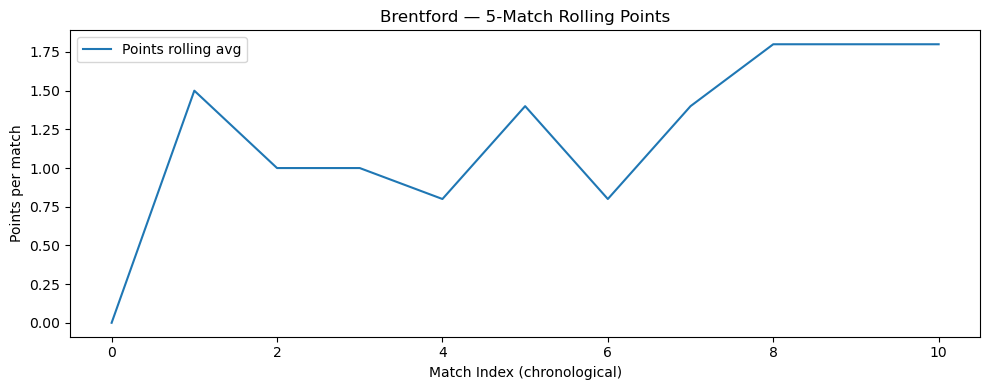

In [32]:
# Distribution
goals = tm_team["GF"].fillna(0).values
plt.figure(figsize=(8,5))
bins = np.arange(0, np.nanmax(goals)+2) - 0.5  # center bins on integers
plt.hist(goals, bins=bins, rwidth=0.9)
plt.xticks(range(int(np.nanmax(goals))+1))
plt.title(f"{TEAM} — Distribution of Goals Scored per Match")
plt.xlabel("Goals For (per match)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Rolling trends (sorted by date)
tm_team_sorted = tm_team.sort_values("Date").reset_index(drop=True)
window = 5  # tweak as you like
roll_GF = tm_team_sorted["GF"].rolling(window, min_periods=1).mean()
roll_GA = tm_team_sorted["GA"].rolling(window, min_periods=1).mean()
roll_Pts = tm_team_sorted["Points"].rolling(window, min_periods=1).mean()

plt.figure(figsize=(10,5))
plt.plot(roll_GF.index, roll_GF.values, label="GF rolling avg")
plt.plot(roll_GA.index, roll_GA.values, label="GA rolling avg")
plt.title(f"{TEAM} — {window}-Match Rolling Goals For / Against")
plt.xlabel("Match Index (chronological)")
plt.ylabel("Goals per match")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(roll_Pts.index, roll_Pts.values, label="Points rolling avg")
plt.title(f"{TEAM} — {window}-Match Rolling Points")
plt.xlabel("Match Index (chronological)")
plt.ylabel("Points per match")
plt.legend()
plt.tight_layout()
plt.show()


Brentford — Shots: 117.0, SOT: 49.0, Shot Accuracy: 0.419
Goals per Shot: 0.145
Goals per SOT: 0.347


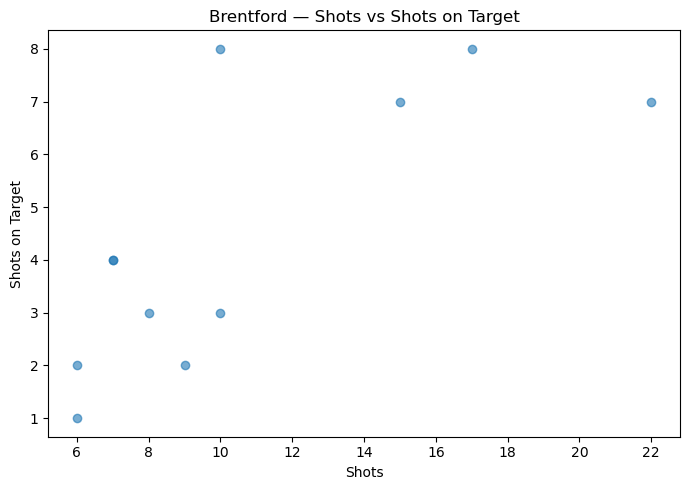

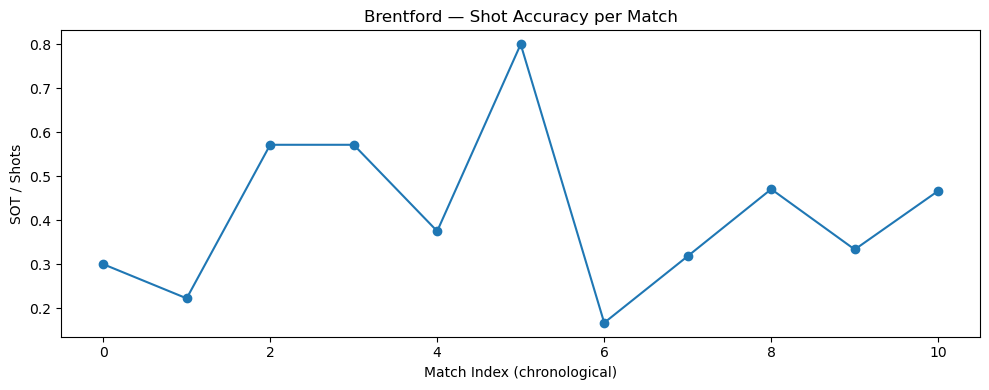

In [33]:
# Aggregates
shots = tm_team["Shots"].sum(skipna=True)
sot = tm_team["SOT"].sum(skipna=True)
gf = tm_team["GF"].sum(skipna=True)
acc = (sot / shots) if (shots and shots > 0) else np.nan
gps = (gf / shots) if (shots and shots > 0) else np.nan
gpsot = (gf / sot) if (sot and sot > 0) else np.nan

print(f"{TEAM} — Shots: {shots}, SOT: {sot}, Shot Accuracy: {acc:.3f}" if pd.notna(acc) else f"{TEAM} — Shot Accuracy: NA")
print(f"Goals per Shot: {gps:.3f}" if pd.notna(gps) else "Goals per Shot: NA")
print(f"Goals per SOT: {gpsot:.3f}" if pd.notna(gpsot) else "Goals per SOT: NA")

# Scatter: Shots vs SOT with trend of GF
mask = tm_team["Shots"].notna() & tm_team["SOT"].notna()

plt.figure(figsize=(7,5))
plt.scatter(tm_team.loc[mask, "Shots"], tm_team.loc[mask, "SOT"], alpha=0.6)
plt.title(f"{TEAM} — Shots vs Shots on Target")
plt.xlabel("Shots")
plt.ylabel("Shots on Target")
plt.tight_layout()
plt.show()

# Shot accuracy per match (line)
plt.figure(figsize=(10,4))
plt.plot(tm_team_sorted.index, tm_team_sorted["ShotAccuracy"], marker='o', linestyle='-')
plt.title(f"{TEAM} — Shot Accuracy per Match")
plt.xlabel("Match Index (chronological)")
plt.ylabel("SOT / Shots")
plt.tight_layout()
plt.show()


Brentford — GA per Match: 1.545, Clean Sheet Rate: 0.182


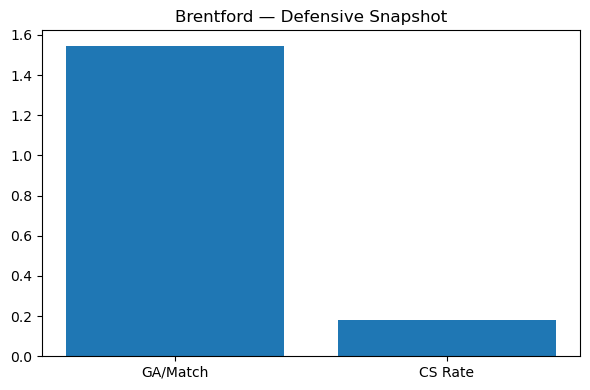

In [34]:
ga_pm = tm_team["GA"].mean()
cs_rate = tm_team["GA"].eq(0).mean()

print(f"{TEAM} — GA per Match: {ga_pm:.3f}, Clean Sheet Rate: {cs_rate:.3f}")

# Bars: GA per match vs Clean sheet rate
plt.figure(figsize=(6,4))
plt.bar(["GA/Match","CS Rate"], [ga_pm, cs_rate])
plt.title(f"{TEAM} — Defensive Snapshot")
plt.tight_layout()
plt.show()


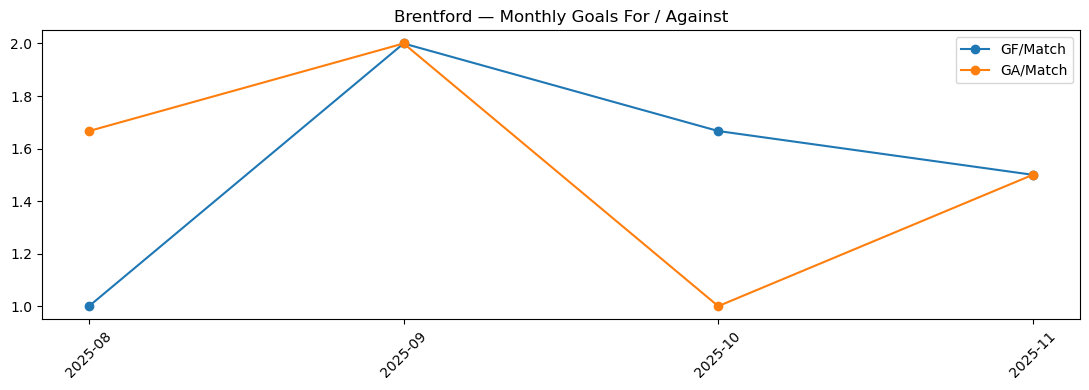

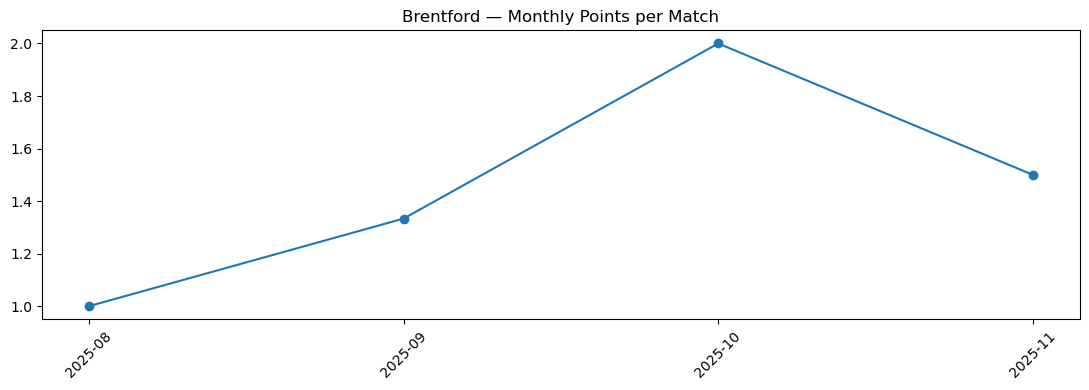

In [35]:
monthly = (tm_team.groupby("Month", as_index=False)
           .agg(
               Matches=("Team","size"),
               GF=("GF","mean"),
               GA=("GA","mean"),
               Pts=("Points","mean"),
           ))

# Keep chronological order by converting Month back to period for sorting
monthly["_order"] = pd.PeriodIndex(monthly["Month"], freq="M")
monthly = monthly.sort_values("_order")

plt.figure(figsize=(11,4))
plt.plot(monthly["_order"].astype(str), monthly["GF"], marker="o", label="GF/Match")
plt.plot(monthly["_order"].astype(str), monthly["GA"], marker="o", label="GA/Match")
plt.xticks(rotation=45)
plt.title(f"{TEAM} — Monthly Goals For / Against")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(11,4))
plt.plot(monthly["_order"].astype(str), monthly["Pts"], marker="o")
plt.xticks(rotation=45)
plt.title(f"{TEAM} — Monthly Points per Match")
plt.tight_layout()
plt.show()


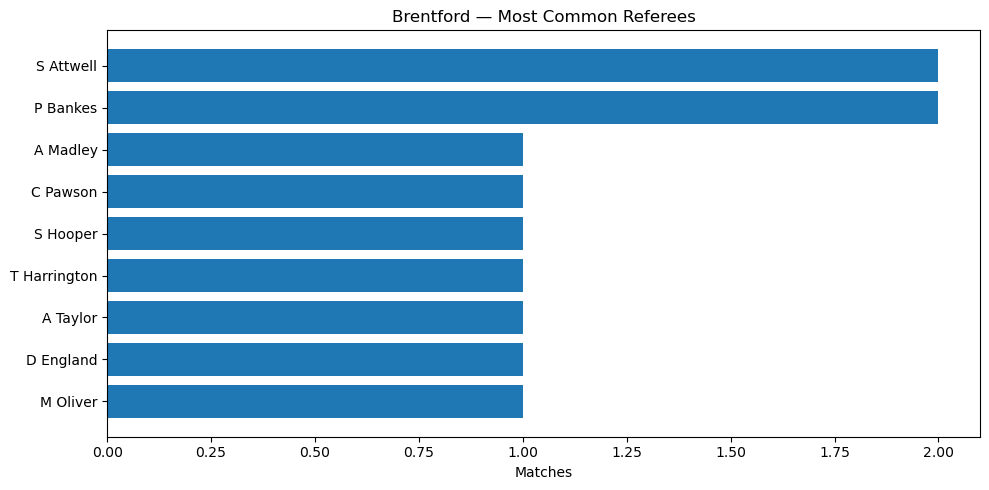

In [36]:
ref_tbl = (tm_team.dropna(subset=["Referee"])
           .groupby("Referee", as_index=False)
           .agg(
               Matches=("Referee","size"),
               PtsPerMatch=("Points","mean"),
               AvgYellows=("Yellows","mean"),
               AvgReds=("Reds","mean"),
               AvgFouls=("Fouls","mean"),
           )
           .sort_values(["Matches","PtsPerMatch"], ascending=[False,False])
          )

ref_tbl.head(15)

top = ref_tbl.head(10)
plt.figure(figsize=(10,5))
plt.barh(top["Referee"], top["Matches"])
plt.gca().invert_yaxis()
plt.title(f"{TEAM} — Most Common Referees")
plt.xlabel("Matches")
plt.tight_layout()
plt.show()
